In [1]:
# important: update to torch 2.0 s.t. pre_hooks are available
# !pip install torch torchvision -U
# !pip install git+https://github.com/huggingface/transformers
# !pip install datasets evaluate

In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader,TensorDataset,random_split
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import torchvision
import numpy as np
import time, os, copy, random
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.0.0
Torchvision Version:  0.15.1+cpu


# Create artifical data

Set random seeds.

In [3]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

Set the number of batches and the batch size. For these early tests, 5 batches of size 3 should give good insights while not being to complicated.

In [4]:
n_batches = 10
batch_size = 3
n_samples = n_batches * batch_size

The network architecture, initial weights and test data is similar to this source:
https://www.kaggle.com/code/sironghuang/understanding-pytorch-hooks.

In the linked notebook, only one datapoint is evaluated. Here, this datapoint will be repeated to include the effects of using batches.

In [5]:
artificial_data = 2*(torch.rand((n_samples,2))-1/2)
print(f'dataset size :{artificial_data.shape}')
print(f'single sample, size: {artificial_data[0,:].shape} | values: {artificial_data[0,:]}')

dataset size :torch.Size([30, 2])
single sample, size: torch.Size([2]) | values: tensor([-0.0075,  0.5364])


In [6]:
artifical_labels = ((artificial_data[:,0]**2 + artificial_data[:,1]**2) < 0.7).int().unsqueeze(1)
print(f'label set size :{artifical_labels.shape}')
print(f'single label, size: {artifical_labels[0,:].shape} | values: {artifical_labels[0,:]}')

label set size :torch.Size([30, 1])
single label, size: torch.Size([1]) | values: tensor([1], dtype=torch.int32)


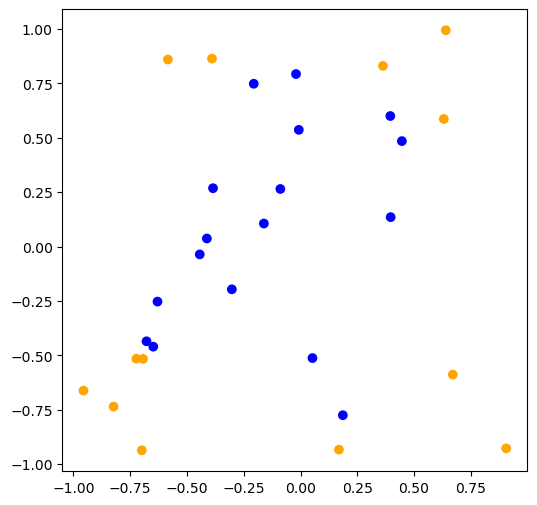

In [7]:
colors = {0:'orange',1:'blue'}
mapped_colors = [colors[label[0]] for label in artifical_labels.tolist()]
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(artificial_data.numpy()[:,0],artificial_data.numpy()[:,1],c=mapped_colors)


Next, the datasets and dataloader are created from the tensors. The first 4*batch_size samples are being used as the training set and the remaining batch_size samples are the test set. The splitting of datasets is not necessary for now but will make extension easy later on.

Tensordata requires a 2D tensor, where each line represents one training sample. Targets may be 1-D or 2-D.

In [8]:
train_set = TensorDataset(artificial_data[:4*batch_size,], artifical_labels[:4*batch_size,])
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
print(f'Number of datapoints in the training set is {len(train_set)}')

Number of datapoints in the training set is 12


In [9]:
eval_set = TensorDataset(artificial_data[4*batch_size:,], artifical_labels[4*batch_size:,])
eval_loader = DataLoader(train_set, batch_size=batch_size, shuffle=False)
print(f'Number of datapoints in the evaluation set is {len(eval_set)}')

Number of datapoints in the evaluation set is 18


In [10]:
dataloaders = {'train':train_loader,
               'eval':eval_loader}

# Create sample model

The base model architecture and weights are taken from [here](https://www.kaggle.com/code/sironghuang/understanding-pytorch-hooks) for reference.

Here, the architecture is extended by a dropout layer.

In [11]:
class TestModel(nn.Module):
  def __init__(self, dropout_rate = 0.5):
        super().__init__()
        self.fc1 = nn.Linear(2,2)
        self.s1 = nn.Sigmoid()
        self.do1 = nn.Dropout(p=dropout_rate)
        self.fc2 = nn.Linear(2,1)
        self.fc1.weight = torch.nn.Parameter(torch.Tensor([[0.15,0.2],[0.250,0.30]]))
        self.fc1.bias = torch.nn.Parameter(torch.Tensor([0.35]))
        self.fc2.weight = torch.nn.Parameter(torch.Tensor([[0.4,0.5]]))
        self.fc2.bias = torch.nn.Parameter(torch.Tensor([0.6]))

  def forward(self, x):
      x= self.fc1(x)
      x = self.s1(x)
      x = self.do1(x)
      x= self.fc2(x)
      return x

In [12]:
model = TestModel()
print(model)

TestModel(
  (fc1): Linear(in_features=2, out_features=2, bias=True)
  (s1): Sigmoid()
  (do1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=2, out_features=1, bias=True)
)


In [13]:
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Layer: fc1.weight | Size: torch.Size([2, 2]) | Values : tensor([[0.1500, 0.2000],
        [0.2500, 0.3000]], grad_fn=<SliceBackward0>) 

Layer: fc1.bias | Size: torch.Size([1]) | Values : tensor([0.3500], grad_fn=<SliceBackward0>) 

Layer: fc2.weight | Size: torch.Size([1, 2]) | Values : tensor([[0.4000, 0.5000]], grad_fn=<SliceBackward0>) 

Layer: fc2.bias | Size: torch.Size([1]) | Values : tensor([0.6000], grad_fn=<SliceBackward0>) 



# Prepare optimizer and loss function

In [14]:
sgd_parameters = {
    'lr':1e-3,        # undefined
    'momentum':0,   # 0
    'dampening':0,    # 0
    'weight_decay':0  # 0
}
optimizer = torch.optim.SGD(model.parameters(), **sgd_parameters)

In [15]:
loss_fn = nn.BCEWithLogitsLoss()

# Hooks

Create two hooks for debugging purposes:
- the forward hook will print the input and output tensor produced during the forward pass.
- the backward hook will print the gradient of the output (the gradient coming from the loss) and the gradient input (the gradient used for following calculations closer to the input layers) during the backward pass. There is a print_eval boolean to determine, if the debugging is only supposed when the model is in eval() mode or only when in train() mode. This is to prevent verbose outputs of uninteresting layers during the unregularized run.

In [16]:
def forward_debug_hook(module, input, output):
  print('forward hook')
  print(input)
  print(output)

class Backward_Debug_Hook():
  def __init__(self, module, layer_name, print_eval=False):
    self.hook = module.register_full_backward_hook(self.hook_fn)
    self.module = module
    self.layer_name = layer_name
    self.print_eval = print_eval

  def hook_fn(self, module, grad_input, grad_output):
    # if-statement checks, that hook is only executed during evaluation OR training
    if (self.module.training and not self.print_eval) or (not self.module.training and self.print_eval):
      print(f'layer: {self.layer_name} with:')
      print('grad_output')
      print(grad_output)
      print('grad_input')
      print(grad_input)
    
  def close(self):
    self.hook.remove() 

In [17]:
debug_hook_dict = {}
affected_layer = model.fc2
affected_name = 'fc2'

for name, module in model.named_modules():
  if not isinstance(module,TestModel):
    debug_hook_dict[name+'_train'] = Backward_Debug_Hook(module,name)

debug_hook_dict[affected_name+'_eval'] = Backward_Debug_Hook(affected_layer,affected_name,print_eval=True)
debug_hook_dict

{'fc1_train': <__main__.Backward_Debug_Hook at 0x28118136d30>,
 's1_train': <__main__.Backward_Debug_Hook at 0x28118136d60>,
 'do1_train': <__main__.Backward_Debug_Hook at 0x28118136700>,
 'fc2_train': <__main__.Backward_Debug_Hook at 0x28118136fa0>,
 'fc2_eval': <__main__.Backward_Debug_Hook at 0x28118136d00>}

Another hook is used to extract the unregularized gradient. The hook is supposed to catch the input gradient (the gradient being sent to the next layer) when reaching the layer before the logits layer (last fc layer of the model).

For this, the hook is created as a class to store the gradient for later use. 

Note that the hook will be attached to the layer the whole time and the stored gradient will simply be overwritten.



In [18]:
class Catch_Hook():
  def __init__(self, module):
    self.hook = module.register_full_backward_hook(self.hook_fn)

  def hook_fn(self, module, grad_input, grad_output):
    self.caught_grad = grad_output
    print('caught a gradient:')
    print(self.caught_grad)

  def close(self):
    self.hook.remove()

catch_hook = Catch_Hook(affected_layer)

Re-insertion of the gradient is a little bit more tricky.

By using the return statement in the backward hook, the gradient can be manipulated. There are two possibilities:
1. using the full_backward_hook will insert the gradient in the return statement as the ***input gradient*** (see [here](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook))
2. using the full_backward_pre_hook will insert the gradient in the return statement as the ***output gradient*** (see [here](https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_pre_hook))

Approach number 2 was not successfull (see remarks at the end of the notebook).

In the logit case, we want to replace the gradient dLoss/dLogits, which is in this case excactly the input gradient of the preceding layer (the sigmoid layer). 

Additionally, we only want to apply this hook during the regularized run. For this the model.training boolean is used. In each batch, the new unregularized gradient is updated via the .update_grad() method.

In [19]:
class Insert_Hook():
  def __init__(self, module, new_grad_output=None):
    self.new_grad_output = new_grad_output
    # use prepend=True so that this is definetly the first hook being applied
    self.hook = module.register_full_backward_pre_hook(self.hook_fn,prepend=True)

  def hook_fn(self, module, grad_output):
    if module.training:
      print('inserted gradient:')
      print(self.new_grad_output)
      # simply return the previously caught grad_output
      # this will replace the current grad_output (if prehook is used)
      # if non-pre hook is used, grad_input will be replaced (not desire in our case)
      return self.new_grad_output
    else:
      print('skipping gradient insertion in eval mode')

  def update_grad(self, new_grad_output):
    self.new_grad_output = new_grad_output

  def close(self):
    self.hook.remove()

# artifical_grad = (100*torch.ones([3,2]),)
artifical_grad = None

insert_hook = Insert_Hook(affected_layer,artifical_grad)

### Important note
The implementation of full_backward_pre_hook contains a bug in torch v.2.0.0 (see here: https://discuss.pytorch.org/t/understanding-gradient-calculation-with-backward-pre-hooks/176154). A fix will be made available in a nightly build soon. Till then, the fix can be applied on the local machine. I have not made the effort to transfer this fix to the colab workspace.

If one wants to compare the training process with the insertion hook to the one without, simply uncomment the last line, where the insert_hook is being created.

# Model training

Comments on the training loops are inside the code.

The general idea for each batch is:
- Run the model in .eval() mode to deactivate dropout and run the backwards pass. Do NOT update the gradients via optimizer.step() and reset the gradients via optimizer.zero_grad(). Catch the desired gradient with the catch_hook.





Caveats to this method:
- using model.eval() will make batchnorms use the rolling average instead of the actual batch distributions. This is not reasonable for this method. An option would be to set the dropout rates in the model to zero by hand and reset them after the unregularized run. Then one would not have to use .eval().

- This approach requires us to do the forward and backward pass twice. This will increase the computational load. The memory consumption is only slighty bigger, as only the gradient of one layer has to be stored.

In [24]:
def train_model(model, dataloaders, loss_fn, optimizer, num_epochs=5):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    n_train_batches = len(dataloaders['train'])

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        ########## train phase ##########
        phase = 'train'
        model.train()

        running_loss = 0.0
        running_corrects = 0

        for batch, (inputs, labels) in enumerate(dataloaders[phase]):
          

          #++++++++ catch unregularized gradient ++++++++#
          optimizer.zero_grad()
          print('*'*5 + 'unregularized run' + '*'*5)
          # with torch.no_grad():
          #   model.eval()
          #   outputs = model(inputs)
          #   loss = loss_fn(outputs, labels.float())
          #   loss.backward()

          model.eval()
          outputs = model(inputs)
          loss = loss_fn(outputs, labels.float())
          loss.backward()
          
          # the following grad computation requires output of the model to be the logits, not the probability.
          # manual_grad = torch.autograd.grad(loss,outputs,retain_graph=True)
          # print(f'calculated gradient d_L/d_logits: {manual_grad}')

          
          #++++++++ \catch unregularized gradient ++++++++#

          #++++++++ update unregularized gradient to be inserted ++++++++#
          insert_hook.update_grad(catch_hook.caught_grad)
          # insert_hook.update_grad(manual_grad)
          #++++++++ \update unregularized gradient to be inserted ++++++++#
          
          # Get model outputs and calculate loss
          model.train()
          optimizer.zero_grad()
          print('*'*5 + 'forward pass' + '*'*5)
          outputs = model(inputs)
          print('model outputs')
          print(outputs)


          print('*'*5 + 'loss calculation' + '*'*5)
          loss = loss_fn(outputs, labels.float())
          print(f'loss: {loss}')

          preds = (outputs>0.5).int()
          

          # backward + optimize
          print('*'*5 + 'backward pass' + '*'*5)
          loss.backward()          
          optimizer.step()

          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        ########## eval phase ##########
        phase = 'eval'
        model.eval()

        running_loss = 0.0
        running_corrects = 0

        for batch, (inputs, labels) in enumerate(dataloaders[phase]):
          # disable gradient tracking for speedup
          with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            loss = loss_fn(outputs, labels.float())
            preds = (outputs>0.5).int()

          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))  

        val_acc_history.append(epoch_acc)
        print()


    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return val_acc_history

In [25]:
with torch.autograd.profiler.profile() as prof:
    hist = train_model(model,
                    dataloaders,
                    loss_fn,
                    optimizer,
                    num_epochs=1
                    )
print(prof.key_averages().table(sort_by="count"))

Epoch 0/0
----------
*****unregularized run*****
skipping gradient insertion in eval mode
layer: fc2 with:
grad_output
(tensor([[-0.0797],
        [ 0.2468],
        [-0.0817]]),)
grad_input
(tensor([[-0.0319, -0.0399],
        [ 0.0987,  0.1234],
        [-0.0327, -0.0408]]),)
caught a gradient:
(tensor([[-0.0797],
        [ 0.2468],
        [-0.0817]]),)
*****forward pass*****
model outputs
tensor([[1.7143],
        [1.0809],
        [0.6000]], grad_fn=<BackwardHookFunctionBackward>)
*****loss calculation*****
loss: 0.6587010025978088
*****backward pass*****
inserted gradient:
(tensor([[-0.0797],
        [ 0.2468],
        [-0.0817]]),)
layer: fc2 with:
grad_output
(tensor([[-0.0797],
        [ 0.2468],
        [-0.0817]]),)
grad_input
(tensor([[-0.0319, -0.0399],
        [ 0.0987,  0.1234],
        [-0.0327, -0.0408]]),)
caught a gradient:
(tensor([[-0.0797],
        [ 0.2468],
        [-0.0817]]),)
layer: do1 with:
grad_output
(tensor([[-0.0319, -0.0399],
        [ 0.0987,  0.1234]

Compare the run with (artifical) gradient insertion (picture right side) to the one without (picture left side). It can be seen that the output gradient is being changed and propagated through the net.

NEW PICTURE

In [26]:
print(affected_layer._backward_hooks)
print(affected_layer._backward_pre_hooks)
print(catch_hook.caught_grad)

OrderedDict([(3, <bound method Backward_Debug_Hook.hook_fn of <__main__.Backward_Debug_Hook object at 0x0000028118136FA0>>), (4, <bound method Backward_Debug_Hook.hook_fn of <__main__.Backward_Debug_Hook object at 0x0000028118136D00>>), (5, <bound method Catch_Hook.hook_fn of <__main__.Catch_Hook object at 0x0000028117E8F280>>)])
OrderedDict([(6, <bound method Insert_Hook.hook_fn of <__main__.Insert_Hook object at 0x000002811813CFD0>>)])
(tensor([[-0.0850],
        [ 0.2555],
        [-0.0795]]),)


# Old variant with backward_pre_hooks

In the old variant, the catch and insert hooks were registered on the fully connected layer. For some reason, the insertion of the gradient_ouput before the computation of gradient_input was successfull, but it didn't change the gradient_input. Therefore this is here for reference purposes. Notice the use of a backward_**pre**_hook

In [88]:
# affected_layer = model.fc2
# affected_name = 'fc2'

In [89]:
# class Catch_Hook_old():
#   def __init__(self, module):
#     self.hook = module.register_full_backward_hook(self.hook_fn)

#   def hook_fn(self, module, grad_input, grad_output):
#     self.caught_grad = grad_output
#     print('caught a gradient')

#   def close(self):
#     self.hook.remove()

# catch_hook = Catch_Hook_old(affected_layer)

In [90]:
# class Insert_Hook_old():
#   def __init__(self, module, new_grad_output=None):
#     self.new_grad_output = new_grad_output
#     # use prepend=True so that this is definetly the first hook being applied
#     self.hook = module.register_full_backward_pre_hook(self.hook_fn)

#   def hook_fn(self, module, grad_output):
#     if module.training:
#       print('inserted gradient')
#       # simply return the previously caught grad_output
#       # this will replace the current grad_output (if prehook is used)
#       # if non-pre hook is used, grad_input will be replaced (not desire in our case)
#       return self.new_grad_output
#     else:
#       print('skipping gradient insertion in eval mode')

#   def update_grad(self, new_grad_output):
#     self.new_grad_output = new_grad_output

#   def close(self):
#     self.hook.remove()

# insert_hook = Insert_Hook_old(affected_layer,artifical_grad)

# Test question

In [91]:
# import torch
# import torch.nn as nn

# class Backward_Debug_Hook():
#   def __init__(self, module):
#     self.hook = module.register_full_backward_hook(self.hook_fn)

#   def hook_fn(self, module, grad_input, grad_output):
#     print('grad_output')
#     print(grad_output)
#     print('grad_input')
#     print(grad_input)
    
#   def close(self):
#     self.hook.remove() 

# class Insert_Hook():
#   def __init__(self, module, new_grad_output=None):
#     self.new_grad_output = new_grad_output
#     self.hook = module.register_full_backward_pre_hook(self.hook_fn)

#   def hook_fn(self, module, grad_output):
#     return self.new_grad_output

#   def close(self):
#     self.hook.remove()

# # simple model
# model = nn.Sequential(
#   nn.Linear(2, 2),
#   nn.Sigmoid(),
#   nn.Linear(2,2)
# )
# last_layer = model[-1]

# debug_hook = Backward_Debug_Hook(last_layer) # attach debug hook
# x = torch.randn(1, 2) # artificial input
# out = model(x) # forward pass
# print('without gradient insertion')
# out.mean().backward() # backward pass


# model.zero_grad()

# artifical_grad = (100*torch.ones([1,2]),)
# insert_hook = Insert_Hook(last_layer,artifical_grad)
# out = model(x) # forward pass
# print('with gradient insertion')
# out.mean().backward() # backward pass

without gradient insertion
grad_output
(tensor([[0.5000, 0.5000]]),)
grad_input
(tensor([[ 0.0976, -0.4175]]),)
with gradient insertion
grad_output
(tensor([[100., 100.]]),)
grad_input
(tensor([[ 19.5118, -83.4977]]),)


# Test glue

In [92]:
# !python run_glue.py \
#   --model_name_or_path bert-base-cased \
#   --task_name RTE \
#   --do_train \
#   --do_eval \
#   --max_seq_length 128 \
#   --per_device_train_batch_size 32 \
#   --learning_rate 2e-5 \
#   --num_train_epochs 3 \
#   --output_dir /tmp/RTE/

# Test loss grad

In [2]:
loss_fn = nn.BCELoss()
loss_fn2 = nn.BCEWithLogitsLoss()
target = torch.FloatTensor([1])
print(target)

tensor([1.])


In [66]:
logit = torch.tensor([0.4],requires_grad=True)
print(f'logit {logit}')
sigmoid = nn.Sigmoid()
proba = sigmoid(logit)
print(f'sigmoid output {proba}')
loss2 = loss_fn2(logit,target)
print(f'loss {loss2}')

print(f'expected loss grad {proba.detach()-target}')
loss_grad = torch.autograd.grad(loss2,logit)
print(f'calculated gradient {loss_grad}')

logit tensor([0.4000], requires_grad=True)
sigmoid output tensor([0.5987], grad_fn=<SigmoidBackward0>)
loss 0.5130152702331543
expected loss grad tensor([-0.4013])
calculated gradient (tensor([-0.4013]),)


In [4]:
logit = torch.tensor([0.4],requires_grad=True)
print(f'logit {logit}')
sigmoid = nn.Sigmoid()
proba = sigmoid(logit)
print(f'sigmoid output {proba}')
loss = loss_fn(logit,target)
print(f'loss {loss2}')

print(f'expected loss grad {proba.detach()-target}')
loss_grad = torch.autograd.grad(loss,logit)
print(f'calculated gradient {loss_grad}')

logit tensor([0.4000], requires_grad=True)
sigmoid output tensor([0.5987], grad_fn=<SigmoidBackward0>)
loss 0.5130152702331543
expected loss grad tensor([-0.4013])
calculated gradient (tensor([-2.5000]),)


In [50]:

x = torch.ones(5)  # input tensor
y = torch.zeros(3)  # expected output
w = torch.randn(5, 3, requires_grad=True)
b = torch.randn(3, requires_grad=True)
z = torch.matmul(x, w)+b
loss = torch.nn.functional.binary_cross_entropy_with_logits(z, y)

In [61]:
z.grad

C:\Users\Valentin\AppData\Local\Temp\ipykernel_22568\4110045842.py:1: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\cb\pytorch_1000000000000\work\build\aten\src\ATen/core/TensorBody.h:491.)
  z.grad


In [63]:
dir(z.grad_fn)

['__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '_register_hook_dict',
 '_saved_alpha',
 'metadata',
 'name',
 'next_functions',
 'register_hook',
 'register_prehook',
 'requires_grad']

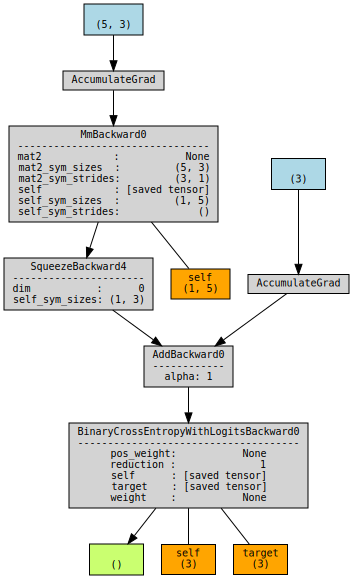

In [51]:
from torchviz import make_dot
make_dot(loss,show_attrs=True,show_saved=True)